In [1]:
!pip install pystoi
from pystoi.stoi import stoi
import pystoi

  Obtaining dependency information for pystoi from https://files.pythonhosted.org/packages/1a/22/60cd92bd3ec00948800984410f4cf5ded5bd8e9b715729f3642efe0edb3d/pystoi-0.4.1-py2.py3-none-any.whl.metadata


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!pip install pesq
from pesq import pesq

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp310-cp310-linux_x86_64.whl size=114849 sha256=4515c18f22ab166a270de0529eeaa48999f04f06ef0b2bd2293e4a56dd0ba022
  Stored in directory: /root/.cache/pip/wheels/c5/4e/2c/251524370c0fdd659e99639a0fbd0ca5a782c3aafcd456b28d
Successfully built pesq


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import scipy
from IPython.core.display import display
import IPython.display as ipd
from tqdm import tqdm
from scipy.io import wavfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import zipfile
import time
import librosa
import matplotlib.pyplot as plt
import shutil
import psutil

/tmp/ipykernel_26/4219493953.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


To verify the effectiveness of the proposed framework, the
standard PESQ function was used to measure the speech quality
and the score ranges from -0.5 to 4.5. We also presented STOI
for speech intelligibility evaluation and the score ranges from 0
to 1. Both the two metrics are the higher the better.

In [4]:
def compute_PESQ(clean_signal, noisy_signal, sr=8000):
    return pesq(sr, clean_signal, noisy_signal, mode='nb')
def compute_STOI(clean_signal, noisy_signal, sr=8000):
    return stoi(clean_signal, noisy_signal, sr, extended=False)

In [5]:
preds = np.random.rand(8000)
target = np.random.rand(8000)
compute_PESQ(preds, target)

2.223867416381836

In [6]:
def print_ram_usage() -> None:
  print(
      f"RAM used: {psutil.virtual_memory()[3] / 10**9} GB "
      f"({psutil.virtual_memory()[2]} %)"
  )


def track_time_memory_usage(func):
    """
    Decorator that measures the execution time and the memory allocated (and not
    deallocated) during the execution of a function.
    """

    @wraps(func)
    def wrapper(*args, **kwargs):
        print(f"Running function {func.__name__}.")
        start_time = perf_counter()
        start_ram = psutil.virtual_memory()[3] / (1024 ** 3)
        start_pct_ram = psutil.virtual_memory()[2]
        print(f"RAM initially used: {start_ram:.4f} GB ({start_pct_ram:.2f} %)")

        result = func(*args, **kwargs)
        
        end_time = perf_counter()
        end_ram = psutil.virtual_memory()[3] / 10 ** 9
        end_pct_ram = psutil.virtual_memory()[2]
        print(f"RAM used after execution: {end_ram:.4f} GB ({end_pct_ram:.2f} %)")
        
        print(
            f"Function {func.__name__} took {end_time - start_time:.2f} seconds"
            f" and increased memory use by {(end_ram - start_ram) * 1024:.4f} MB"
            f" ({end_pct_ram - start_pct_ram:.2f} %).\n"
        ) 
        return result

    return wrapper

In [7]:
print_ram_usage()

RAM used: 0.82761728 GB (3.9 %)


## Data Exploration

In [7]:
root_path = '/kaggle/input/signals/data/'
train_small_path = root_path + 'train_small/'
train_path = root_path + 'train/'
test_path = root_path + 'test/'

In [8]:
train_clean_folder = os.path.join(train_path, 'original/signal')
train_noisy_folder = os.path.join(train_path, 'noisy/signal')
test_clean_folder = os.path.join(test_path, 'original/signal')
test_noisy_folder = os.path.join(test_path, 'noisy/signal')
print("Number of training samples : ", len(os.listdir(train_noisy_folder) ))
print("Number of testing samples : ", len(os.listdir(test_noisy_folder)))

Number of training samples :  2118
Number of testing samples :  782


In [10]:
#sample noisy and clean signals
noisy_path = train_small_path + "noisy/signal/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_6_.wav"
clean_path = train_small_path + "original/signal/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_6_.wav"

fs_noisy, sig_noisy = scipy.io.wavfile.read(noisy_path)
fs_clean, sig_clean = scipy.io.wavfile.read(clean_path)

print("noisy singnal:")
display(ipd.Audio(data= sig_noisy, rate= fs_noisy))

print("clean signal:")
display(ipd.Audio(data= sig_clean, rate=fs_clean))

In [11]:
print('signals length :', len(sig_noisy), len(sig_clean))
print('sampling rates :', fs_noisy, fs_clean)

In [12]:
#Sanity checks
from pathlib import Path

pathlist = Path(root_path).glob('**/*.wav')
for signal_path in pathlist:
    fs, sig = scipy.io.wavfile.read(signal_path)
    assert len(sig) == 80000
    assert fs == 8000


In [13]:
import librosa.display
sig_clean_float = np.array(sig_clean).astype(np.float32)
librosa.display.waveshow(sig_clean_float, sr=8000)
librosa.display.waveshow(sig_noisy, sr=8000)

We need to scale input and target signals

## Preprocessing

In [9]:
def scale_signal(signal):
  signal_max = np.max(np.abs(signal.astype(np.float32)))
  scaled_signal = signal/signal_max
  return scaled_signal

In [15]:
#Checking that this does not alter audio
sig_clean_scaled = scale_signal(sig_clean)
display(ipd.Audio(data= sig_clean, rate= fs_clean))
display(ipd.Audio(data= sig_clean_scaled, rate= fs_clean))


In [16]:
sig_noisy_scaled = scale_signal(sig_noisy)
display(ipd.Audio(data= sig_noisy_scaled, rate= fs_clean))


In [17]:
import librosa.display
librosa.display.waveshow(sig_noisy_scaled, label='noisy', sr=8000)
librosa.display.waveshow(sig_clean_scaled, label='clean', sr=8000)
plt.legend()

In [18]:
librosa.display.waveshow(sig_noisy_scaled-sig_clean_scaled, sr=8000)

Characteristics of our data : 
1. Signals have the same number of samples and same sampling rate
2. There is a point-to-point correspondance between noisy and clean signals
3. Signals are nearly 8 times longueur than the signals in the VCTK dataset, which Wave UNet has been tested on
4. Few data points

Taking advantage of this, we can **divide our input and target signals into patches that correspond in time, use these patches as training data (==> More data) and merge the output patches back according to filename**  

# Deep Learning method

## Model

In [10]:
class DownSamplingLayer(nn.Module):
    def __init__(self, channel_in, channel_out, dilation=1, kernel_size=15, stride=1, padding=7):
        super(DownSamplingLayer, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(channel_in, channel_out, kernel_size=kernel_size,
                      stride=stride, padding=padding, dilation=dilation),
            nn.BatchNorm1d(channel_out),
            nn.LeakyReLU(negative_slope=0.1)
        )

    def forward(self, ipt):
        return self.main(ipt)

class UpSamplingLayer(nn.Module):
    def __init__(self, channel_in, channel_out, kernel_size=5, stride=1, padding=2):
        super(UpSamplingLayer, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(channel_in, channel_out, kernel_size=kernel_size,
                      stride=stride, padding=padding),
            nn.BatchNorm1d(channel_out),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
        )

    def forward(self, ipt):
        return self.main(ipt)

class Model(nn.Module):
    def __init__(self, n_layers=6, channels_interval=24):
        super(Model, self).__init__()

        self.n_layers = n_layers
        self.channels_interval = channels_interval
        encoder_in_channels_list = [1] + [i * self.channels_interval for i in range(1, self.n_layers)]
        encoder_out_channels_list = [i * self.channels_interval for i in range(1, self.n_layers + 1)]

            # Original Article
        # 0     => 1    => 2    => 3    => 4    => 5    => 6   => 7   => 8   => 9  => 10 => 11 =>12
        # 16384 => 8192 => 4096 => 2048 => 1024 => 512 => 256 => 128 => 64 => 32 => 16 =>  8 => 4
            # First approach, input way too long
        #     0 =>     1 =>     2 =>     3 =>    4 =>    5 =>    6 =>   7
        # 80000 => 40000 => 20000 => 10000 => 5000 => 2500 => 1250 => 625
        # Second approach, input devided in patches
            # Second approach, patches as input
        #     0 =>     1 =>     2 =>     3 =>    4 =>    5 =>    6 =>   7
        # 16000 =>  8000 =>  4000 =>  2000 => 1000 =>  500 =>  250 => 125
 
        self.encoder = nn.ModuleList()

        for i in range(self.n_layers):
            self.encoder.append(
                DownSamplingLayer(
                    channel_in=encoder_in_channels_list[i],
                    channel_out=encoder_out_channels_list[i]
                )
            )

        self.middle = nn.Sequential(
            nn.Conv1d(self.n_layers * self.channels_interval, self.n_layers * self.channels_interval, 15, stride=1,
                      padding=7),
            nn.BatchNorm1d(self.n_layers * self.channels_interval),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )

        #
        decoder_in_channels_list = [(2 * i + 1) * self.channels_interval for i in range(1, self.n_layers)] + [
            2 * self.n_layers * self.channels_interval]
        decoder_in_channels_list = decoder_in_channels_list[::-1]
        decoder_out_channels_list = encoder_out_channels_list[::-1]
        self.decoder = nn.ModuleList()
        for i in range(self.n_layers):
            self.decoder.append(
                UpSamplingLayer(
                    channel_in=decoder_in_channels_list[i],
                    channel_out=decoder_out_channels_list[i]
                )
            )

        self.out = nn.Sequential(
            nn.Conv1d(1 + self.channels_interval, 1, kernel_size=1, stride=1),
            nn.Tanh()
        )

    def forward(self, input):
        tmp = []
        o = input
        # print('------------------------------------- INPUT : ',o.shape)

        # print('\n---------------------------------- DOWNSAMPLING : ')

        # Down Sampling
        for i in range(self.n_layers):
            o = self.encoder[i](o)
            # print(self.encoder[i])
            # print(o.shape, ' saved as skip connection of layer', i)
            tmp.append(o)
            # [batch_size, T // 2, channels]
            o = o[:, :, ::2]
            # print(o.shape)

        # print('\n------------------------------------ MIDDLE : ')
        o = self.middle(o)
        # print(self.middle)
        # print(o.shape)

        # print('\n---------------------------------- UPSAMPLING : ')
        # Up Sampling
        for i in range(self.n_layers):
            # [batch_size, T * 2, channels]
            o = F.interpolate(o, scale_factor=2, mode="linear", align_corners=True)
            # print(o.shape, '(interpolate, scale_factor =2)')
            # Skip Connection
            # print(tmp[self.n_layers - i - 1].shape, 'skip connection of layer ',self.n_layers - i - 1 )
            o = torch.cat([o, tmp[self.n_layers - i - 1]], dim=1)
            # print(o.shape, 'after combining skip connection and upsampled input')
            o = self.decoder[i](o)
            # print(self.decoder[i])
            # print(o.shape, '(output)')

        # print('\n---------------------------------COMBINE WITH INPUT and OUT')
        o = torch.cat([o, input], dim=1)
        o = self.out(o)
        return o

In [11]:
# Example usage
B = 4  # Batch size
input_signal = torch.randn(B, 1, 40000)  # (B, Length)
model = Model(6,24)
output_signal = model(input_signal)

print(f"Input shape: {input_signal.shape}, Output shape: {output_signal.shape}")

Input shape: torch.Size([4, 1, 40000]), Output shape: torch.Size([4, 1, 40000])


## Loss

In [13]:
mse_loss = torch.nn.MSELoss()
l1_loss = torch.nn.L1Loss()

## Dataset

### Utility functions to segment signals

In [14]:
# Function to divide the audio signal into patches
def divide_into_patches_and_save(audio_path, patch_size, target_directory):
    sample_rate, signal = wavfile.read(audio_path)

    # Ensure patch size is an integer number of frames
    patch_size = int(patch_size)
    # Calculate the number of patches
    num_patches = int(np.ceil(len(signal) / patch_size))    
    # Create patches
    patches = np.array_split(signal, num_patches)
    # Ensure all patches have the same size
    patches = [np.pad(p, (0, max(0, patch_size - len(p))), 'constant') for p in patches]
    
    filename = audio_path.split('/')[-1].split('.wav')[0]
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)
    paths_patches = []
    for i, patch in enumerate(patches):
        patch_path = os.path.join(target_directory, f'{filename}--{i}.wav')
        wavfile.write(patch_path, sample_rate, patch.astype(np.float32)) 
        paths_patches.append(patch_path)
    return paths_patches

# Function to load patches from disk associated with a specific filename
def load_patches_and_join(directory, filename):
    # List all files in the directory
    all_files = os.listdir(directory)
    # Filter out the files that match the filename pattern
    patch_files = [f for f in all_files if f.startswith(filename) and f.endswith('.wav')]
    # Sort the files to maintain the correct order
    patch_files.sort(key=lambda x: int(x.split('--')[1].split('.wav')[0]))
    patches = []
    # Load each patch
    for patch_file in patch_files:
        patch_path = os.path.join(directory, patch_file)
        sr, patch = wavfile.read(patch_path)
        # Assuming all patches have the same sample rate
        patches.append(patch)
    # Concatenate all patches into a single signal
    return np.concatenate(patches)

In [24]:
# audio_path = clean_path
# patch_size = 8000 
# patch_directory = 'test'

# divide_into_patches_and_save(audio_path, patch_size, patch_directory)

# filename = audio_path.split('/')[-1].split('.wav')[0]
# sample_rate = 8000

# reloaded_signal = load_patches_and_join(patch_directory, filename)

# # Step 6: Save the reconstructed audio stream to a new file
# reconstructed_audio_path = 'reconstructed_audio.wav'
# wavfile.write(reconstructed_audio_path, 8000, reloaded_signal.astype(np.float32))

# print(f'Reconstructed audio saved to {reconstructed_audio_path}')
# display(ipd.Audio(data= reloaded_signal, rate= sample_rate))



In [15]:
class Wave_Dataset(Dataset):
    def __init__(self, data_path, patch_size=None, split=None, p=1.0):
        """Construct dataset for training and validation.
        Args:
            data_path (str): directory path, containing all signal wavfiles (train or test).
            patch_size (None/int): if not None, we divide each signal into equal length patches
            split (str): "train"/"val"/None to get subsets of train data
            p (float): if split is not None, p is proportion of train samples, 1-p is proportion of validation samples
        Return:
            (noisy signal, clean signal, filename)
        """
        print(f"Loading data from {data_path}: ")
        super(Dataset, self).__init__()
        self.data_path = data_path
        self.patch_size = patch_size
        self.split = split
        
        print("\tLoading clean data...")
        clean_folder = os.path.join(self.data_path, "original/signal")
        self.clean_data = list(map(lambda x:os.path.join(clean_folder, x), os.listdir(clean_folder)))
        
        print("\tLoading noisy data...")
        noisy_folder = os.path.join(self.data_path, "noisy/signal")
        self.noisy_data = list(map(lambda x:os.path.join(noisy_folder, x), os.listdir(noisy_folder)))
        print(f"\tdata loaded.")
        
        if patch_size : 
            self.clean_data, self.noisy_data = self._make_patches()
        
        assert len(self.clean_data) == len(self.noisy_data)
        if split :
            limit = int(len(self.clean_data)*p)  
            if split == 'train':
                self.clean_data = self.clean_data[:limit]
                self.noisy_data = self.noisy_data[:limit]
                print(len(self.noisy_data))
            if split == 'val':
                self.clean_data = self.clean_data[limit:]
                self.noisy_data = self.noisy_data[limit:]
                print(len(self.noisy_data))


    def _make_patches(self):
        if "train" in self.data_path: #train or val
            if self.split=='val':
                target_dir = 'processed/val/'
                print('loading val')
            else:
                target_dir = 'processed/train/'
                print('loading train')
        else:
            target_dir = 'processed/test/'
            print('loading test')
        clean_data_processed = []
        noisy_data_processed = []
        for i in range(len(self.noisy_data)):
            clean_abs_path, noisy_abs_path = self.clean_data[i], self.noisy_data[i]
            clean_patches = divide_into_patches_and_save(clean_abs_path, self.patch_size, target_dir+'original/')
            noisy_patches = divide_into_patches_and_save(noisy_abs_path, self.patch_size, target_dir+'noisy/')
            clean_data_processed += clean_patches
            noisy_data_processed += noisy_patches
        return clean_data_processed, noisy_data_processed

    def __len__(self):
        return len(self.noisy_data)

    def __getitem__(self, idx):
        clean_path, noisy_path = self.clean_data[idx], self.noisy_data[idx]
        filename = os.path.splitext(os.path.basename(noisy_path))[0]
        _, clean = wavfile.read(clean_path)
        _, noisy = wavfile.read(noisy_path)
        clean_scaled = scale_signal(clean)
        noisy_scaled = scale_signal(noisy)
        return noisy_scaled.reshape(1, -1), clean_scaled.reshape(1, -1), filename

In [16]:
train_dataset = Wave_Dataset(train_path, patch_size=40000, split='train', p=0.9)
print(len(train_dataset))
val_dataset = Wave_Dataset(train_path,patch_size=40000, split='val', p=0.9)
test_dataset = Wave_Dataset(test_path, patch_size=40000)
print(len(test_dataset))
# train_small_dataset = Wave_Dataset(train_small_path, patch_size=8000)

Loading data from /kaggle/input/signals/data/train/: 
	Loading clean data...
	Loading noisy data...
	data loaded.
loading train
3812
3812
Loading data from /kaggle/input/signals/data/train/: 
	Loading clean data...
	Loading noisy data...
	data loaded.
loading val
424
Loading data from /kaggle/input/signals/data/test/: 
	Loading clean data...
	Loading noisy data...
	data loaded.
loading test
1564


In [34]:
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [18]:
for batch in test_loader:
  print(batch[0].shape)
  break

torch.Size([10, 1, 40000])


## Training

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

Using device: cuda


Model(
  (encoder): ModuleList(
    (0): DownSamplingLayer(
      (main): Sequential(
        (0): Conv1d(1, 24, kernel_size=(15,), stride=(1,), padding=(7,))
        (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
    )
    (1): DownSamplingLayer(
      (main): Sequential(
        (0): Conv1d(24, 48, kernel_size=(15,), stride=(1,), padding=(7,))
        (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
    )
    (2): DownSamplingLayer(
      (main): Sequential(
        (0): Conv1d(48, 72, kernel_size=(15,), stride=(1,), padding=(7,))
        (1): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
    )
    (3): DownSamplingLayer(
      (main): Sequential(
        (0): Conv1d(72, 96, kernel_size=(15,), stride=(1,), padding=(7,))
       

In [30]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

1487042

In [31]:
print_ram_usage()

RAM used: 1.586552832 GB (6.2 %)


In [32]:
seed = 0
epochs = 50
best_val_loss = 100000
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [33]:
# logs_dir = "logs"

In [34]:
# from torch.utils.tensorboard import SummaryWriter

# def writer(logs_dir):
#     return SummaryWriter(max_queue=5, flush_secs=30)
# my_writer = writer(logs_dir)

To log a scalar value, use
``add_scalar(tag, scalar_value, global_step=None, walltime=None)``

In [ ]:
print('loading best model...')
checkpoint = torch.load("/kaggle/input/dlts-models/best_model_29_01.pt")
model.load_state_dict(checkpoint)

In [35]:
train_losses = []
val_losses = []
all_stoi_cn = []
all_stoi_ce = []
all_pesq_cn = []
all_pesq_ce = []
val_no_impv = 0
halving = False
prev_val_loss = 0

for epoch in range(epochs):
    
    print(f"============== Epoch : {epoch} ==============")
    time1 = time.time()
    
    model.train()
    loss_train = 0.0
    for i, (noisy, clean, name) in enumerate(train_loader):
        noisy = noisy.to(device)
        clean = clean.to(device)
        enhanced = model(noisy).to(device)
        loss = mse_loss(clean, enhanced)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
    train_losses.append(loss_train / len(train_loader))    
    
##############################################################################################

    model.eval()
    val_loss = 0.0
    epoch_pesq_cn = []
    epoch_pesq_ce = []
    epoch_stoi_cn = []
    epoch_stoi_ce = []
    for i_, (noisy, clean, name) in enumerate(val_loader):
        noisy = noisy.to(device)
        clean = clean.to(device)
        enhanced = model(noisy).to(device)
        loss = mse_loss(clean, enhanced)
        val_loss += loss.item()
        
        clean_np = clean.detach().cpu().numpy()
        enhanced_np = enhanced.detach().cpu().numpy()
        noisy_np = noisy.detach().cpu().numpy()
        
        # Compute PESQ and STOI for each sample in the batch
        
        batch_pesq_cn = [] #cn : clean vs noisy
        batch_pesq_ce = [] #ce : clean vs enhanced
        
        batch_stoi_cn = [] 
        batch_stoi_ce = []
        
        for i in range(clean_np.shape[0]):
            pesq_ce = compute_PESQ(clean_np[i].squeeze(), enhanced_np[i].squeeze())
            batch_pesq_ce.append(pesq_ce)
            pesq_cn = compute_PESQ(clean_np[i].squeeze(), noisy_np[i].squeeze())
            batch_pesq_cn.append(pesq_cn)
            
            stoi_ce = compute_STOI(clean_np[i].squeeze(), enhanced_np[i].squeeze())
            batch_stoi_ce.append(stoi_ce)
            stoi_cn = compute_STOI(clean_np[i].squeeze(), noisy_np[i].squeeze())
            batch_stoi_cn.append(stoi_cn)
            
        epoch_pesq_cn += batch_pesq_cn
        epoch_pesq_ce += batch_pesq_ce
        
        epoch_stoi_cn += batch_stoi_cn
        epoch_stoi_ce += batch_stoi_ce
    
    mean_pesq_cn = np.mean(epoch_pesq_cn)
    mean_pesq_ce = np.mean(epoch_pesq_ce)
    mean_stoi_cn = np.mean(epoch_stoi_cn)
    mean_stoi_ce = np.mean(epoch_stoi_ce)
    mean_loss_val = val_loss / len(val_loader)
    val_losses.append(mean_loss_val)
    print(f'Training loss : {100* loss_train / len(train_loader):.4f} | Validation loss : {100*mean_loss_val:.4f}')
    print(f'STOI before denoising : {mean_stoi_cn:.3f}, STOI after : {mean_stoi_ce:.3f}')
    print(f'PESQ before denoising : {mean_pesq_cn:.3f}, PESQ after : {mean_pesq_ce:.3f}')
    
    if (mean_loss_val)<best_val_loss:
        save_path = f'best_model.pt'
        torch.save(model.state_dict(), save_path)
        print('-----------saving model')
        best_val_loss = (mean_loss_val)
        
    if mean_loss_val >= prev_val_loss:
        val_no_impv += 1
        if val_no_impv >= 3:
            halving = True
        if val_no_impv >= 10:
            print("No improvement for 10 epochs, early stopping.")
            break
    else:
        val_no_impv = 0
    if halving:
        optim_state = optimizer.state_dict()
        optim_state['param_groups'][0]['lr'] = optim_state['param_groups'][0]['lr'] / 2.0
        optimizer.load_state_dict(optim_state)
        print(f"Learning rate adjusted to: {optim_state['param_groups'][0]['lr']:.6f}")
        halving = False

    print(f"[{time.time()-time1} seconds] .")
    all_stoi_cn.append(mean_stoi_cn)
    all_stoi_ce.append(mean_stoi_ce)
    all_pesq_cn.append(mean_pesq_cn)
    all_pesq_ce.append(mean_pesq_ce)
    prev_val_loss = mean_loss_val


============== Epoch : 0 ==============

Training loss : 0.5334 | Validation loss : 0.0403

STOI before denoising : 0.913, STOI after : 0.819

PESQ before denoising : 2.590, PESQ after : 2.443

-----------saving model

[175.8609597682953 seconds] .

============== Epoch : 1 ==============

Training loss : 0.0391 | Validation loss : 0.0332

STOI before denoising : 0.913, STOI after : 0.873

PESQ before denoising : 2.590, PESQ after : 2.552

-----------saving model

[176.34281158447266 seconds] .

============== Epoch : 2 ==============

Training loss : 0.0332 | Validation loss : 0.0302

STOI before denoising : 0.913, STOI after : 0.884

PESQ before denoising : 2.590, PESQ after : 2.554

-----------saving model

[175.7258539199829 seconds] .

============== Epoch : 3 ==============

Training loss : 0.0308 | Validation loss : 0.0274

STOI before denoising : 0.913, STOI after : 0.889

PESQ before denoising : 2.590, PESQ after : 2.569

-----------saving model

[176.031672000885 seconds] .



In [ ]:
# It seems the Matplotlib library needs to be re-imported due to the reset of the code execution state
import matplotlib.pyplot as plt

# Compiling the training and validation loss values for each epoch into lists
training_loss = [
    0.1090, 0.0766, 0.0723, 0.0698, 0.0695, 0.0659, 0.0652, 0.0652, 0.0644, 0.0625, 
    0.0667, 0.0622, 0.0602, 0.0597, 0.0570, 0.0580, 0.0565, 0.0555, 0.0538, 0.0541, 
    0.0544, 0.0534, 0.0524, 0.0514, 0.0521, 0.0506, 0.0507, 0.0509, 0.0532, 0.0489, 
    0.0490, 0.0485, 0.0488, 0.0463, 0.0457, 0.0458, 0.0451, 0.0446, 0.0449, 0.0444, 
    0.0440, 0.0439, 0.0439, 0.0442, 0.0438, 0.0443, 0.0445, 0.0436, 0.0428, 0.0430
]

validation_loss = [
    0.0764, 0.0782, 0.0671, 0.0798, 0.0805, 0.0676, 0.0589, 0.0656, 0.0698, 0.0695, 
    0.0565, 0.0707, 0.0571, 0.0529, 0.0606, 0.0508, 0.0577, 0.0606, 0.0519, 0.0698, 
    0.0482, 0.0574, 0.0476, 0.0452, 0.0508, 0.0460, 0.0458, 0.0656, 0.0463, 0.0443, 
    0.0445, 0.0469, 0.0497, 0.0399, 0.0419, 0.0405, 0.0404, 0.0402, 0.0412, 0.0398, 
    0.0429, 0.0420, 0.0393, 0.0419, 0.0397, 0.0409, 0.0428, 0.0398, 0.0413, 0.0401
]

epochs = list(range(50))

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='x')
plt.title('Training and Validation Loss Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('loss.png')

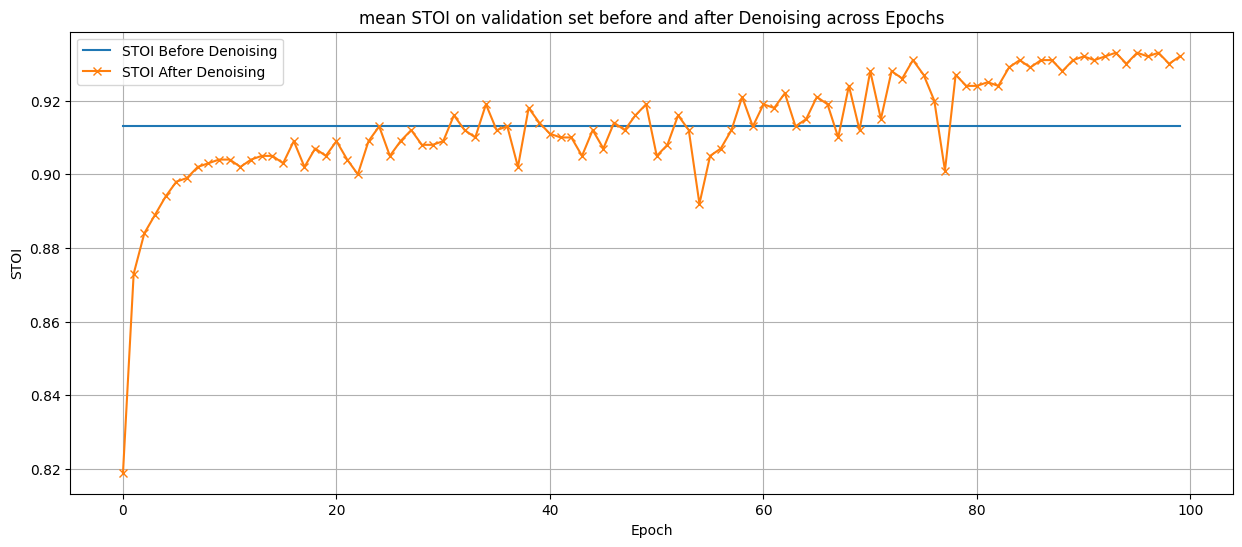

<Figure size 640x480 with 0 Axes>

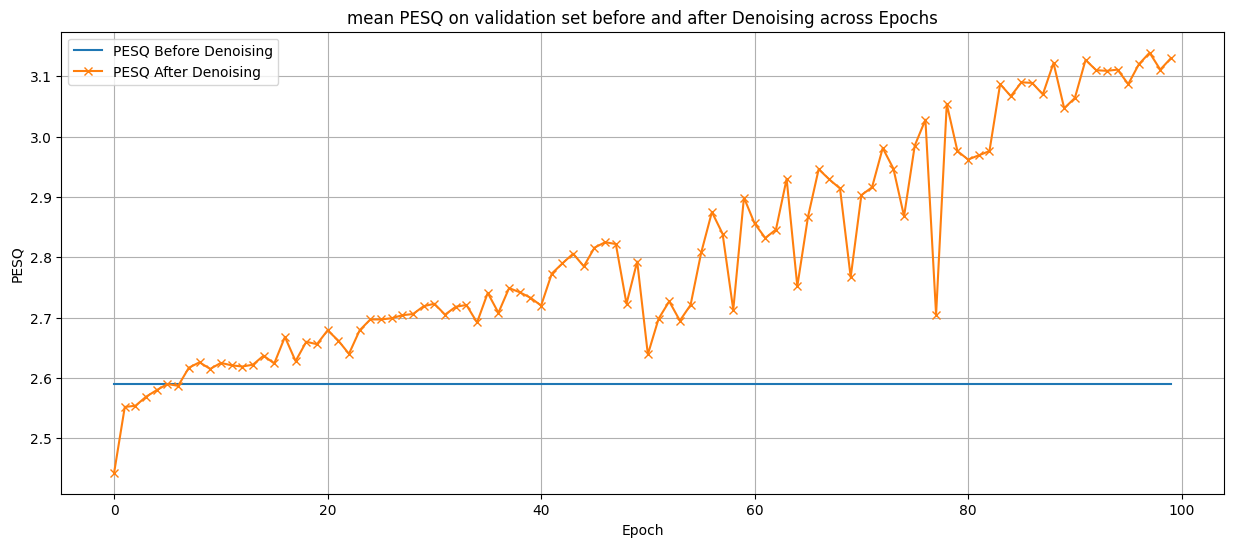

<Figure size 640x480 with 0 Axes>

In [36]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(100))

# STOI values before and after denoising
stoi_before = [0.913] * 50
stoi_after = [0.819, 0.873, 0.884, 0.889, 0.894, 0.898, 0.899, 0.902, 0.903, 0.904, 
              0.904, 0.902, 0.904, 0.905, 0.905, 0.903, 0.909, 0.902, 0.907, 0.905, 
              0.909, 0.904, 0.900, 0.909, 0.913, 0.905, 0.909, 0.912, 0.908, 0.908, 
              0.909, 0.916, 0.912, 0.910, 0.919, 0.912, 0.913, 0.902, 0.918, 0.914, 
              0.911, 0.910, 0.910, 0.905, 0.912, 0.907, 0.914, 0.912, 0.916, 0.919]
stoi_before +=  [0.913] * 50
stoi_after +=  [0.905, 0.908, 0.916, 0.912, 0.892, 0.905, 0.907, 0.912, 0.921, 0.913, 0.919, 0.918, 0.922, 0.913, 0.915, 0.921, 0.919, 0.910, 0.924, 0.912, 0.928, 0.915, 0.928, 0.926, 0.931, 0.927, 0.920, 0.901, 0.927, 0.924, 0.924, 0.925, 0.924, 0.929, 0.931, 0.929, 0.931, 0.931, 0.928, 0.931, 0.932, 0.931, 0.932, 0.933, 0.930, 0.933, 0.932, 0.933, 0.930, 0.932]

# PESQ values before and after denoising
pesq_before = [2.590] * 50
pesq_after = [2.443, 2.552, 2.554, 2.569, 2.580, 2.590, 2.587, 2.617, 2.626, 2.615, 
              2.625, 2.621, 2.619, 2.622, 2.637, 2.624, 2.668, 2.628, 2.660, 2.656, 
              2.679, 2.662, 2.640, 2.679, 2.697, 2.697, 2.699, 2.704, 2.706, 2.719, 
              2.723, 2.705, 2.718, 2.721, 2.692, 2.741, 2.708, 2.749, 2.742, 2.733, 
              2.720, 2.773, 2.790, 2.806, 2.785, 2.816, 2.825, 2.822, 2.723, 2.793]
pesq_before += [2.590] * 50
pesq_after += [2.639, 2.698, 2.727, 2.695, 2.721, 2.808, 2.875, 2.839, 2.713, 2.899,
 2.856, 2.832, 2.846, 2.930, 2.752, 2.867, 2.946, 2.929, 2.914, 2.767,
 2.903, 2.916, 2.981, 2.947, 2.868, 2.985, 3.028, 2.705, 3.054, 2.976,
 2.962, 2.969, 2.976, 3.087, 3.067, 3.090, 3.089, 3.070, 3.122, 3.047,
 3.064, 3.127, 3.110, 3.109, 3.111, 3.087, 3.120, 3.139, 3.111, 3.130]

# Plotting STOI
plt.figure(figsize=(15, 6))
plt.plot(epochs, stoi_before, label='STOI Before Denoising')
plt.plot(epochs, stoi_after, label='STOI After Denoising', marker='x')
plt.title('mean STOI on validation set before and after Denoising across Epochs')
plt.xlabel('Epoch')
plt.ylabel('STOI')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('STOI_before_after.png')

# Plotting PESQ
plt.figure(figsize=(15, 6))
plt.plot(epochs, pesq_before, label='PESQ Before Denoising')
plt.plot(epochs, pesq_after, label='PESQ After Denoising', marker='x')
plt.title('mean PESQ on validation set before and after Denoising across Epochs')
plt.xlabel('Epoch')
plt.ylabel('PESQ')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('PESQ_before_after.png')


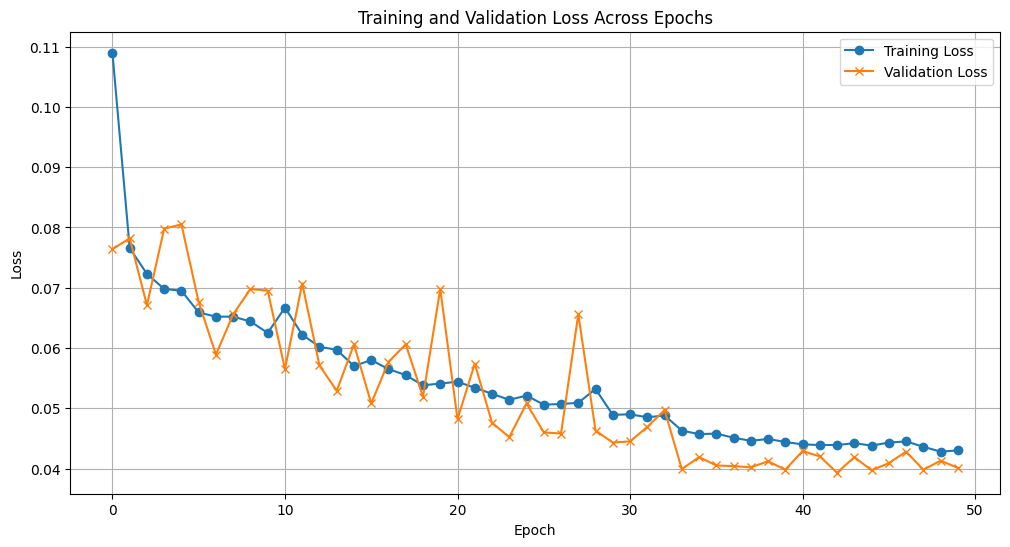

In [22]:
# It seems the Matplotlib library needs to be re-imported due to the reset of the code execution state
import matplotlib.pyplot as plt

# Compiling the training and validation loss values for each epoch into lists
training_loss = [
    0.1090, 0.0766, 0.0723, 0.0698, 0.0695, 0.0659, 0.0652, 0.0652, 0.0644, 0.0625, 
    0.0667, 0.0622, 0.0602, 0.0597, 0.0570, 0.0580, 0.0565, 0.0555, 0.0538, 0.0541, 
    0.0544, 0.0534, 0.0524, 0.0514, 0.0521, 0.0506, 0.0507, 0.0509, 0.0532, 0.0489, 
    0.0490, 0.0485, 0.0488, 0.0463, 0.0457, 0.0458, 0.0451, 0.0446, 0.0449, 0.0444, 
    0.0440, 0.0439, 0.0439, 0.0442, 0.0438, 0.0443, 0.0445, 0.0436, 0.0428, 0.0430
]

validation_loss = [
    0.0764, 0.0782, 0.0671, 0.0798, 0.0805, 0.0676, 0.0589, 0.0656, 0.0698, 0.0695, 
    0.0565, 0.0707, 0.0571, 0.0529, 0.0606, 0.0508, 0.0577, 0.0606, 0.0519, 0.0698, 
    0.0482, 0.0574, 0.0476, 0.0452, 0.0508, 0.0460, 0.0458, 0.0656, 0.0463, 0.0443, 
    0.0445, 0.0469, 0.0497, 0.0399, 0.0419, 0.0405, 0.0404, 0.0402, 0.0412, 0.0398, 
    0.0429, 0.0420, 0.0393, 0.0419, 0.0397, 0.0409, 0.0428, 0.0398, 0.0413, 0.0401
]

epochs = list(range(50))

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='x')
plt.title('Training and Validation Loss Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [41]:
#Test set

In [26]:
# print('loading best model...')
checkpoint = torch.load("/kaggle/input/dlts-models/ZE_BEST_MODEL.pt")
model.load_state_dict(checkpoint)

<All keys matched successfully>

STOI before denoising : 0.906, STOI after : 0.929
PESQ before denoising : 2.466, PESQ after : 3.026


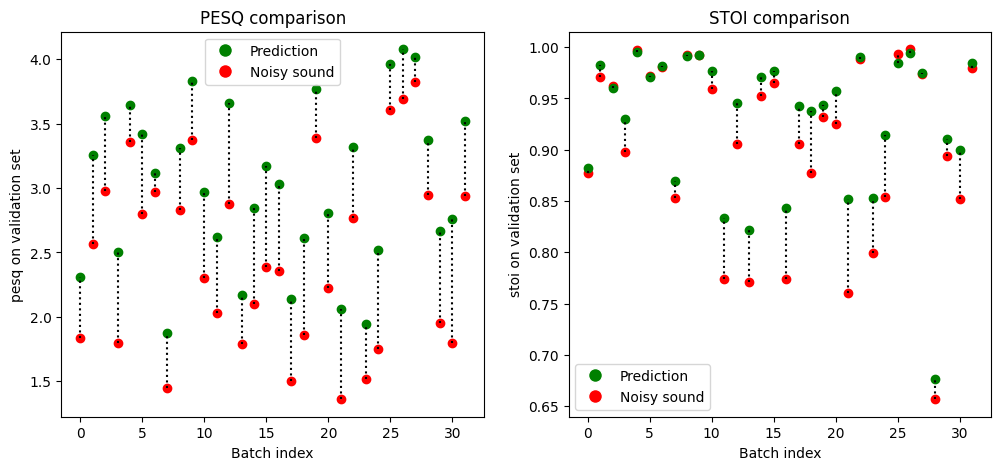


You can listen to one element in the batch (chosen randomly) using the widgets below.

Noisy signal




Target signal




Denoised signal



<Figure size 640x480 with 0 Axes>

In [35]:
from matplotlib.lines import Line2D
for i_, (noisy, clean, name) in enumerate(test_loader):
        noisy = noisy.to(device)
        clean = clean.to(device)
        enhanced = model(noisy).to(device)
        
        clean_np = clean.detach().cpu().numpy()
        enhanced_np = enhanced.detach().cpu().numpy()
        noisy_np = noisy.detach().cpu().numpy()
        
        # Compute PESQ and STOI for each sample in the batch
        
        batch_pesq_cn = [] #cn : clean vs noisy
        batch_pesq_ce = [] #ce : clean vs enhanced
        
        batch_stoi_cn = [] 
        batch_stoi_ce = []
        
        for i in range(clean_np.shape[0]):
            pesq_ce = compute_PESQ(clean_np[i].squeeze(), enhanced_np[i].squeeze())
            batch_pesq_ce.append(pesq_ce)
            pesq_cn = compute_PESQ(clean_np[i].squeeze(), noisy_np[i].squeeze())
            batch_pesq_cn.append(pesq_cn)
            
            stoi_ce = compute_STOI(clean_np[i].squeeze(), enhanced_np[i].squeeze())
            batch_stoi_ce.append(stoi_ce)
            stoi_cn = compute_STOI(clean_np[i].squeeze(), noisy_np[i].squeeze())
            batch_stoi_cn.append(stoi_cn)
            # plotting the metrics
        print(f'STOI before denoising : {np.mean(batch_stoi_cn):.3f}, STOI after : {np.mean(batch_stoi_ce):.3f}')
        print(f'PESQ before denoising : {np.mean(batch_pesq_cn):.3f}, PESQ after : {np.mean(batch_pesq_ce):.3f}')
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        for i in range(noisy.shape[0]):
            ax1.scatter(i, batch_pesq_cn[i], c='r')
            ax1.scatter(i, batch_pesq_ce[i], c='g')
            ax1.vlines(i, ymin=min(batch_pesq_cn[i], batch_pesq_ce[i]), 
               ymax=max(batch_pesq_cn[i], batch_pesq_ce[i]), color='black', linestyle=':')

            ax2.scatter(i, batch_stoi_cn[i], c='r')
            ax2.scatter(i, batch_stoi_ce[i], c='g')
            ax2.vlines(i, ymin=min(batch_stoi_cn[i], batch_stoi_ce[i]), 
               ymax=max(batch_stoi_cn[i], batch_stoi_ce[i]), color='black', linestyle=':')
        legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Prediction', markerfacecolor='g', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Noisy sound', markerfacecolor='r', markersize=10)
        ]

        ax1.legend(handles=legend_elements)
        ax2.legend(handles=legend_elements)
        ax1.set(title="PESQ comparison", xlabel="Batch index", ylabel="pesq on validation set")
        ax2.set(title="STOI comparison", xlabel="Batch index", ylabel="stoi on validation set")

        plt.show()

        # direct comparison by ear
        idx = np.random.randint(0, batch_size - 1)

        print("\nYou can listen to one element in the batch (chosen randomly) using the widgets below.")
        print("\nNoisy signal\n")
        display(ipd.Audio(noisy_np[idx], rate=8000))
        print("\nTarget signal\n")
        display(ipd.Audio(clean_np[idx], rate=8000))
        print("\nDenoised signal\n")
        display(ipd.Audio(enhanced_np[idx], rate=8000))
        
        plt.savefig('inference.png')
        break
        

## Tensorboard

In [ ]:
# !pip install tensorboard

In [ ]:
# LOG_DIR = 'logs'
# get_ipython().system_raw(
#     'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
#     .format(LOG_DIR)
# )

In [ ]:
# ! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# ! unzip ngrok-stable-linux-amd64.zip

In [ ]:
# get_ipython().system_raw('./ngrok http 6006 &')
# ! curl -s http://localhost:4040/api/tunnels | python3 -c \
#         "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [ ]:
# import numpy as np
# from scipy.signal import welch

# train_noisy_signals = list(map(lambda x : os.path.join(train_noisy_folder,x),os.listdir(train_noisy_folder)))
# train_clean_signals = list(map(lambda x : os.path.join(train_clean_folder,x),os.listdir(train_clean_folder)))

# def get_signal_at(list, idx):
#   fs, signal = scipy.io.wavfile.read(list[idx])
#   return scale_signal(signal)

# # Estimate the PSD of the noise and the signal
# # For simplicity, we're assuming noise is the difference between noisy and clean signals
# noise_psd = np.mean([welch(get_signal_at(train_noisy_signals, i) - get_signal_at(train_clean_signals, i))[1] for i in range(len(train_noisy_signals))], axis=0)
# signal_psd = np.mean([welch(get_signal_at(train_clean_signals, i))[1] for i in range(len(train_clean_signals))], axis=0)

# # Design the Wiener filter based on the PSD estimates
# wiener_filter = signal_psd / (signal_psd + noise_psd)

# test_noisy_signals = list(map(lambda x : os.path.join(test_noisy_folder,x),os.listdir(test_noisy_folder)))
# test_clean_signals = list(map(lambda x : os.path.join(test_clean_folder,x),os.listdir(test_clean_folder)))

# # Apply the Wiener filter to the test set
# stoi_before = []
# stoi_after = []
# for i in range(len(test_noisy_signals)):
#     # Apply the Wiener filter in the frequency domain
#     test_noisy_signal = get_signal_at(test_noisy_signals,i)
#     S_test_noisy = np.fft.rfft(test_noisy_signal)
#     S_filtered = S_test_noisy * wiener_filter
#     test_denoised_signal = np.fft.irfft(S_filtered)
#     stoi_before.append(compute_STOI(get_signal_at(train_clean_signals, i),test_noisy_signal))
#     stoi_after.append(compute_STOI(test_denoised_signal, test_noisy_signal))

# print("noisy singnal:")
# display(ipd.Audio(data= test_noisy_signal, rate= fs_noisy))

# print("enhanced signal:")
# display(ipd.Audio(data= test_denoised_signal, rate=fs_noisy))

